In [1]:
import pandas as pd
import math
import json
import re
import numpy as np
import matplotlib.pyplot as plt
# import sys
from wordcloud import WordCloud
from PIL import Image
import datetime as dt

In [2]:
df=pd.read_csv("../data/CometLandingFixed.csv", 
                dtype={"id_str": str, "in_reply_to_user_id_str": str, "from_user_id_str": str,
                        "in_reply_to_status_id_str": str, "user_followers_count": "Int64",
                        "user_friends_count": "Int64", "geo_coordinates" : str}, parse_dates=['created_at']
              )

In [3]:
df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56..."
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,"<a href=""https://dev.twitter.com/docs/tfw"" rel...",http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77305,532460148238090240,nsentse,7 hours of waiting #CometLanding,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,20434005,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3693655850...,200,267,http://twitter.com/nsentse/statuses/5324601482...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."


In [4]:
#Filter dates
#https://www.geeksforgeeks.org/select-pandas-dataframe-rows-between-two-dates/
start_date = '2014-11-12'
end_date = '2014-12-06' 
mask = (df['created_at'] >= start_date) & (df['created_at'] < end_date)

In [5]:
df.loc[mask]

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56..."
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,"<a href=""https://dev.twitter.com/docs/tfw"" rel...",http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77305,532460148238090240,nsentse,7 hours of waiting #CometLanding,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,20434005,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3693655850...,200,267,http://twitter.com/nsentse/statuses/5324601482...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."


In [6]:
type(df["created_at"])

pandas.core.series.Series

In [7]:
len(df)

77307

In [8]:
df.dtypes

id_str                                    object
from_user                                 object
text                                      object
created_at                   datetime64[ns, UTC]
geo_coordinates                           object
user_lang                                 object
in_reply_to_user_id_str                   object
in_reply_to_screen_name                   object
from_user_id_str                          object
in_reply_to_status_id_str                 object
source                                    object
profile_image_url                         object
user_followers_count                       Int64
user_friends_count                         Int64
status_url                                object
entities_str                              object
dtype: object

In [9]:
df[df.duplicated()].head(20)

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str


In [10]:
df = df.drop_duplicates()
df = df.dropna(axis = 0, how = 'all')

In [11]:
reply_df = df[["in_reply_to_user_id_str","in_reply_to_screen_name","in_reply_to_status_id_str"]]

In [12]:
reply_df

,in_reply_to_user_id_str,in_reply_to_screen_name,in_reply_to_status_id_str
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
77302,NaN,NaN,NaN
77303,NaN,NaN,NaN
77304,NaN,NaN,NaN
77305,NaN,NaN,NaN


In [13]:
#reply
def isreply(tweet):
    if not pd.isna(tweet):
    
        print(tweet)
        



In [14]:
total_replies = df[pd.notna(df["in_reply_to_user_id_str"])] #replies

In [15]:
len(total_replies.index) # amount of replies

1724

In [16]:
# print all replies
replies = reply_df["in_reply_to_user_id_str"].map(isreply)

11348282
19442947
253536357
253536357
64643056
33602654
1691515789
19402238
529722897
2294593507
41333964
253536357
66162716
59220577
253536357
1273487113
253536357
17842366
26030180
24129206
14526045
21436960
1969346438
253536357
253536357
2232463302
1438925534
15808765
472670056
2590415228
254659730
17384099
177594666
46959037
32520240
443080433
412396499
208442526
86070159
21436960
253536357
253536357
253536357
253536357
208442526
35233873
376790816
404818828
14800111
622113
1266281
2294593507
372434360
329600057
972651
208442526
168090600
246693449
27650674
208442526
1941637627
43024906
86336234
208442526
19903360
2868449663
47306483
371152085
2894572724
106442779
208442526
364423298
253536357
43024906
85751142
208442526
4620451
3108351
41712825
75052666
5402612
2254751592
629637909
21584325
110462645
208442526
5402612
14606395
208442526
75052666
1041442471
119473816
1435461
208442526
229632990
75052666
34800396
32498911
18505048
208442526
208442526
129673790
75052666
114085696
673

In [17]:
raw_total_replies_df = df[pd.notna(df['in_reply_to_user_id_str'])]

In [18]:
raw_total_replies_df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
29,540896030628532224,einfachbloggen,Congrats MT @NASA: #Orion's flying free for th...,2014-12-05 15:50:37+00:00,NaN,de,11348282,NASA,398268735,540891938275467000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5098209126...,191,199,http://twitter.com/einfachbloggen/statuses/540...,"{""hashtags"":[{""text"":""Orion"",""indices"":[19,25]..."
64,540776048414031872,gwittrapp,@nathanbroon last month you tagged 10 tweets w...,2014-12-05 07:53:51+00:00,NaN,en-gb,19442947,nathanbroon,1673116172,NaN,"<a href=""http://gwittr.com"" rel=""nofollow"">Gwi...",http://pbs.twimg.com/profile_images/3788000004...,139,531,http://twitter.com/gwittrapp/statuses/54077604...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
108,540556460443594752,acolliver615,"@ESA_Rosetta keep sending pictures, they're ep...",2014-12-04 17:21:17+00:00,"loc: 39.2076777,-83.6107315",en,253536357,ESA_Rosetta,2260971996,540554322535534000,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/5329781788...,56,364,http://twitter.com/acolliver615/statuses/54055...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
127,540488420062429185,WillemelliW,@ESA_Rosetta kan een puntje zuigen aan de vers...,2014-12-04 12:50:55+00:00,NaN,en,253536357,ESA_Rosetta,1201626438,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3283427317...,29,113,http://twitter.com/WillemelliW/statuses/540488...,"{""hashtags"":[{""text"":""OrionLaunch"",""indices"":[..."
128,540482901624647682,Chapuler38,@RT_com @NASA Looking for miracles? Then #orio...,2014-12-04 12:29:00+00:00,NaN,en,64643056,RT_com,205378951,540481604666556000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/4434806916...,466,477,http://twitter.com/Chapuler38/statuses/5404829...,"{""hashtags"":[{""text"":""orion"",""indices"":[41,47]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76974,532460309639094272,whereisyvette,@purplefroglet also FYI I am bringing prosecco...,2014-11-12 09:10:05+00:00,NaN,en,18061411,purplefroglet,123421220,532459942679429000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/980798471/...,1820,944,http://twitter.com/whereisyvette/statuses/5324...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77198,532460192571883520,arrayson,â€œ@charlieowen4: Seven hours until Philae lan...,2014-11-12 09:09:37+00:00,NaN,en-gb,56183928,charlieowen4,1912388480,532459997771202000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/4887538097...,483,596,http://twitter.com/arrayson/statuses/532460192...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77250,532460171843629056,drfarres,@ESA_Rosetta congratulatins for the separation...,2014-11-12 09:09:32+00:00,NaN,ca,253536357,ESA_Rosetta,190801607,532459086462615000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/2312825800...,159,352,http://twitter.com/drfarres/statuses/532460171...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77254,532460170513625088,cocoy,â€œ@verge: Rosetta's probe just began its prec...,2014-11-12 09:09:31+00:00,NaN,en,275686563,verge,1147491,532459464155484000,"<a href=""http://itunes.apple.com/us/app/twitte...",http://pbs.twimg.com/profile_images/4849003519...,4493,1997,http://twitter.com/cocoy/statuses/532460170513...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."


In [19]:
retweet_replies = raw_total_replies_df[raw_total_replies_df['text'].apply(lambda x: True if re.search('^RT @.*', x) else False)]
tweet_replies =raw_total_replies_df[raw_total_replies_df['text'].apply(lambda x: False if re.search('^RT @.*', x) else True)]

In [20]:
nan_reply_user_id_df = df[pd.isna(df['in_reply_to_user_id_str'])]
retweet_only_df = nan_reply_user_id_df[nan_reply_user_id_df['text'].apply(lambda x: True if re.search("^RT @.*",x)else False)]
tweet_only_df = nan_reply_user_id_df[nan_reply_user_id_df['text'].apply(lambda x: False if re.search("^RT @.*",x)else True)] 

In [21]:
retweet_only_df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56..."
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices..."
5,540928707947671555,MBernacconi,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:00:28+00:00,NaN,en,NaN,NaN,47907492,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/5331943059...,317,478,http://twitter.com/MBernacconi/statuses/540928...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77300,532460149668343808,m0cvo,RT @ConversationUK: BREAKING: Philae lander ha...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,103211582,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5001938819...,1430,845,http://twitter.com/m0cvo/statuses/532460149668...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77301,532460149215350784,ipanice,RT @esa: '@Philae2014 is gone - it's on its pa...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,39744088,NaN,"<a href=""http://itunes.apple.com/us/app/twitte...",http://pbs.twimg.com/profile_images/1667935129...,157,350,http://twitter.com/ipanice/statuses/5324601492...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."


In [22]:
tweet_only_df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,"<a href=""https://dev.twitter.com/docs/tfw"" rel...",http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
6,540928513906589696,LukeGolds,USA Â» NEWS Â» HOT NEWS 828 comet landing Phi...,2014-12-05 17:59:42+00:00,NaN,en,NaN,NaN,619629656,NaN,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",http://pbs.twimg.com/profile_images/2344739619...,350,<NA>,http://twitter.com/LukeGolds/statuses/54092851...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
9,540925590111789056,shaunmajumder,Feels good to be the @CBCDay6 champion beating...,2014-12-05 17:48:05+00:00,NaN,en,NaN,NaN,17680518,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1312790905...,67013,1973,http://twitter.com/shaunmajumder/statuses/5409...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices..."
10,540925056533413888,EUCouncil,After the #CometLanding - Astronaut @astro_luc...,2014-12-05 17:45:58+00:00,NaN,en,NaN,NaN,206717989,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/4838611162...,52050,360,http://twitter.com/EUCouncil/statuses/54092505...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
11,540924908797448193,LukeGolds,USA Â» NEWS Â» HOT NEWS 534 comet landing The...,2014-12-05 17:45:22+00:00,NaN,en,NaN,NaN,619629656,NaN,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",http://pbs.twimg.com/profile_images/2344739619...,350,<NA>,http://twitter.com/LukeGolds/statuses/54092490...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77287,532460156567580672,JoeGrish1,"And go! Philae separates from Rosetta, but sig...",2014-11-12 09:09:28+00:00,NaN,pl,NaN,NaN,2387053214,NaN,"<a href=""http://twitterfeed.com"" rel=""nofollow...",http://pbs.twimg.com/profile_images/4441120804...,173,38,http://twitter.com/JoeGrish1/statuses/53246015...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77290,532460155859120128,charliecbs,It will take seven hours for the #probe to fal...,2014-11-12 09:09:28+00:00,NaN,en,NaN,NaN,169495645,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3788000006...,2163,66,http://twitter.com/charliecbs/statuses/5324601...,"{""hashtags"":[{""text"":""probe"",""indices"":[33,39]..."
77297,532460154482999296,worldbreakingn,"And go! Philae separates from Rosetta, but sig...",2014-11-12 09:09:28+00:00,NaN,pl,NaN,NaN,2309819160,NaN,"<a href=""http://twitterfeed.com"" rel=""nofollow...",http://pbs.twimg.com/profile_images/4270311610...,532,472,http://twitter.com/worldbreakingn/statuses/532...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."


In [23]:
len(retweet_replies.index) #replies that contain retweets


30

In [24]:
len(tweet_replies.index) # replying other tweets

1694

In [25]:
retweet_total = df[df['text'].apply(lambda x: True if re.search('^RT @.*', x) else False)]
tweet_total = df[df['text'].apply(lambda x: False if re.search('^RT @.*', x) else True)]


In [26]:
len(retweet_total.index) # Total retweets

59959

In [27]:
len(tweet_total.index) # Total tweets

17348

In [28]:
retweet_only = len(retweet_total.index) - len(retweet_replies.index)

In [29]:
tweet_only = len(tweet_total.index) - len(tweet_replies.index)

In [30]:
replies_only = len(total_replies.index)

In [31]:
retweet_only

59929

In [32]:
len(retweet_only_df)

59929

In [33]:
tweet_only

15654

In [34]:
len(tweet_only_df)

15654

In [35]:
replies_only

1724

In [36]:
len(raw_total_replies_df)

1724

In [37]:
user_ids = df["from_user_id_str"].unique()

In [38]:
len(user_ids)

50216

In [39]:
len(retweet_only_df["from_user_id_str"].unique())

40925

In [40]:
df[df["id_str"].duplicated()].head(20) #Dup tweet id

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str


In [41]:
average_different_users_tweet = df.groupby(["from_user_id_str"]).agg(["count"])["from_user"]

In [42]:
average_different_users_tweet.mean()

count    1.539489
dtype: float64

In [43]:
average_different_users_tweet.sort_values(by="count",ascending=False)

,count
from_user_id_str,
2851551783,116
356021744,99
32427002,88
619629656,82
1401527256,81
...,...
2300275412,1
230038610,1
23006973,1


In [44]:
man = average_different_users_tweet["count"].tolist() #manual

In [45]:
sum(man)/len(man)

1.5394894057670863

In [46]:
len(man)

50216

In [82]:
average_retweets_by_a_user = len(retweet_only_df) / len(man)
average_tweets_by_a_user = len(tweet_only_df) / len(man)
average_replies_by_a_user = len (raw_total_replies_df) / len(man)

In [83]:
print("Average tweets by a user: " + str(average_tweets_by_a_user))
print("Average retweets by a user: " + str(average_retweets_by_a_user))
print("Average replies by a user: " + str(average_replies_by_a_user))

Average tweets by a user: 0.3117333120917636
Average retweets by a user: 1.193424406563645
Average replies by a user: 0.034331687111677556


In [49]:
user_ids.tolist()[0]

'1297570116'

In [50]:

index = average_different_users_tweet.index
# print(index)
a_list = list(index)


In [51]:
#user_ids.tolist()


[item for item in user_ids.tolist() if item not in a_list]

[]

In [52]:
df.loc[pd.isna(df['from_user_id_str'])] #Nan problem

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str


In [53]:
source = df.groupby(["source"]).agg(["count"])["id_str"]

In [54]:
source

,count
source,
"<a href=""Http://WWW.tweetpooh.cl/download"" rel=""nofollow"">Miguebot</a>",1
"<a href=""http://011.ru"" rel=""nofollow"">severok</a>",6
"<a href=""http://SuperNoder.com/TrendTweeter.php"" rel=""nofollow"">TrendTweeter</a>",1
"<a href=""http://aaplab.com"" rel=""nofollow"">Robird for Android</a>",4
"<a href=""http://actiance.com/support/socialite.aspx"" rel=""nofollow"">Socialite Archiver</a>",1
...,...
"<a href=""https://www.google.fr"" rel=""nofollow"">FirmYn's twit</a>",1
"<a href=""https://www.imanindependentdeveloperwhodontneednowebsite.gov"" rel=""nofollow"">suckmyspiderdickbot</a>",18
"<a href=""https://www.twitter.com/desinewsytweets"" rel=""nofollow"">India News As It Happens</a>",1


In [55]:
source_raw = source.sort_values(by="count",ascending=False)

In [56]:
source_raw

,count
source,
"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",27943
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",13750
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",12773
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",4081
"<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",3283
...,...
"<a href=""http://viralizzer.com"" rel=""nofollow"">ViraliZzer</a>",1
"<a href=""http://twtkr.com"" rel=""nofollow"">twtkr</a>",1
"<a href=""http://twitterstreams.nl"" rel=""nofollow"">rettiwtstreams</a>",1


In [57]:
b = source_raw.index
b_list= list(b)

In [58]:
type(source_raw["count"][1])

numpy.int64

In [59]:
source_raw["count"][1]

13750

In [60]:
b_list

['<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
 '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
 '<a href="http://dlvr.it" rel="nofollow">dlvr.it</a>',
 '<a href="https://dev.twitter.com/docs/tfw" rel="nofollow">Twitter for Websites</a>',
 '<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iÎŸS</a>',
 '<a href="http://www.twitter.com" rel="nofollow">Twitter for Windows Phone</a>',
 '<a href="http://www.ajaymatharu.com/" rel="nofollow">Tweet Old Post</a>',
 '<a href="http://itunes.apple.com/us/app/twitter/id409789998?mt=12" rel="nofollow">Twitter for Mac</a>',
 '<a href="https://twitter.com/download/android" rel="nofollow">Twitter for Android Tablets</

In [61]:
def findDevice(src):
    if (pd.isna(src)):
        return "Unknown"
    elif (re.search('iphone', src) != None):
        return "IOS"
    elif (re.search('ipad', src) != None):
        return "IOS"
    elif (re.search('android', src) != None):
        return "Android"
    else :
        return "Unknown"
    
def getDevice(row, ds):
    user = row['from_user_id_str']
    src = row['source']
    dev = findDevice(row['source'])
    if dev != 'Unknown':
        curDev = ds.setdefault(user, set())
        curDev.add(dev)
        ds.update({user: curDev})
        
def ctDevices(df):
    ds = dict()
    df.apply(lambda row: getDevice(row, ds), axis = 1)
    return ds

In [62]:
def devicesChart(df):
    devices = ctDevices(df).values()
    ios = len([x for x in devices if x == {"IOS"}])
    android = len([x for x in devices if x == {"Android"}])
    both = len([x for x in devices if x == {"IOS", "Android"}])
    total = len({x for x in set(df['from_user_id_str']) if pd.notna(x)})
    unknown = total - len(devices)
    dev_num = np.array([ios, android, both, unknown])
    dev_labels = [f"IOS only: {ios} ({round(ios/total*100, 2)}%)", 
                  f"Android only: {android} ({round(android/total*100, 2)}%)", 
                  f"Both IOS and Android: {both} ({round(both/total*100, 2)}%)", 
                  f"Unknown: {unknown} ({round(unknown/total*100, 2)}%)"]
    # https://stackoverflow.com/questions/19852215/how-to-add-a-legend-to-matplotlib-pie-chart
    patches, texts = plt.pie(dev_num)
    plt.legend(patches, dev_labels, loc="lower left")
    plt.show()

In [63]:
def getListOfAllHashTags():
	# Open JSON file.
	with open('../data/CometLandingFixed.json', 'r', encoding="utf8") as json_file:
		json_load = json.load(json_file)

	# List of hashtags found
	hashtagsFull = []

	# Gets list of hashtags from JSON file.
	for j in json_load:
		for i in j['hashtags']:
			hashtagsFull.append(i['text'])
	json_file.close()
	return hashtagsFull

def getListOfUniqueHashtags(hashtagsFull):
	# Gets unique hashtags.
	hashtagsUnique = pd.Series(hashtagsFull)
	hashtagsUnique = hashtagsUnique.unique()
	return hashtagsUnique

def createDataFrameOfHashtagsAndFills(hashtagsUnique, hashtagsFull):
	# Creates dataframe.
	data = {'Hashtags': hashtagsUnique, 'Frequency': [0] * len(hashtagsUnique)}  
	df = pd.DataFrame(data)  


	# Finds frequency of each hashtag found.
	for i in hashtagsFull:
		for index, j in enumerate(df['Hashtags']):
			if(i == j):
				df['Frequency'][index] += 1

	# Sort values to descending.
	df = df.sort_values(['Frequency'], ascending=False)
	return df
	
def printData(hashtagDataFrame):	
	# Print dataframe.
	print(hashtagDataFrame)

# Example usage 
#allHashtags = getListOfAllHashTags()
#uniqueHashtags = getListOfUniqueHashtags(allHashtags)
#hashtagData = createDataFrameOfHashtagsAndFills(uniqueHashtags, allHashtags)
#printData(hashtagData)

In [64]:
def refine_id(df):
    def id_from_row(r):
        status = r['status_url']
        if pd.notnull(status):
            if re.search("^http://twitter\.com/.+/statuses/[0-9]{18}", status):
                return status[-18:]
            else: 
                return r['id_str']
        else:
            return r['id_str']
    df['id_str'] = df.apply(id_from_row, axis=1)

In [65]:
refine_id(df)

In [66]:
def filter_df(df):
    df = df[df['entities_str'].str.contains("cometlanding",case=True)] #filter tweets without hashtag "cometlanding"

In [80]:
filter_df(df)

In [81]:
df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56..."
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,"<a href=""https://dev.twitter.com/docs/tfw"" rel...",http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77305,532460148238090240,nsentse,7 hours of waiting #CometLanding,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,20434005,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3693655850...,200,267,http://twitter.com/nsentse/statuses/5324601482...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."


In [69]:
len(df['id_str'].unique())

77307

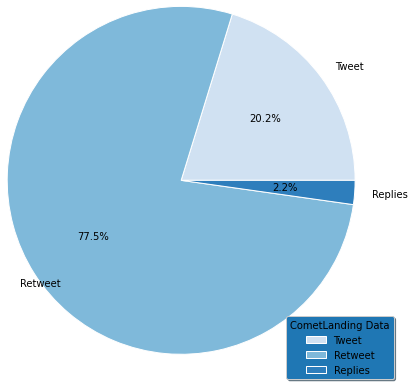

In [70]:
# https://matplotlib.org/stable/plot_types/stats/pie.html#sphx-glr-plot-types-stats-pie-py
# https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

# data
x = [len(tweet_only_df),len(retweet_only_df),len(raw_total_replies_df)]
colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))

# plot
fig, ax = plt.subplots()
ax.pie(x, colors=colors, radius=2, center=(3, 3),labels=["Tweet", "Retweet", "Replies"],
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=False,
      autopct="%1.1f%%")

legend = ax.legend(loc='best', bbox_to_anchor=(1, -0.6, 0.5, 0.5), 
                   shadow=True, fontsize='medium', title = "CometLanding Data")


# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

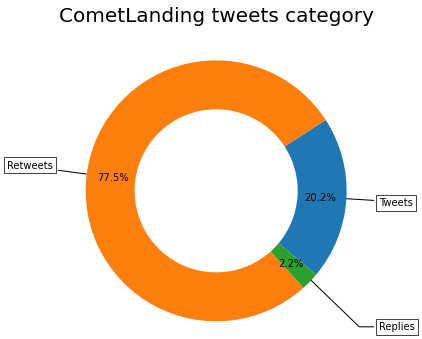

In [71]:
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pie.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

label = ["Tweets",
          "Retweets",
          "Replies"]

data = [len(tweet_only_df),len(retweet_only_df),len(raw_total_replies_df)]

wedges, texts, autotexts = ax.pie(data, wedgeprops=dict(width=0.75), startangle=-40,
                                  autopct="%1.1f%%",pctdistance=0.8, 
                                  radius=2, center=(0,0))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(label[i], xy=(x*1.25, y*1.2), xytext=(2.5*np.sign(x), 3*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("CometLanding tweets category",y=1.5,
             fontdict = {"fontsize":20})

plt.show()

In [72]:
date_raw = df[df['created_at'].apply(lambda x: True if re.search('^2014-11-12', str(x)) else False)]

In [73]:
date_raw

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str
4056,532671396942344192,2553_3,RT @T4914T: Touchdown! My new address: 67P! #C...,2014-11-12 23:08:52+00:00,NaN,en,NaN,NaN,2881297946,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/5272435722...,19,30,http://twitter.com/2553_3/statuses/53267139694...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4057,532671395827048448,Tim_A_Roberts,Fuck you #CometLanding ...I've just landed on ...,2014-11-12 23:08:51+00:00,NaN,en,NaN,NaN,22677215,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5299272572...,2558,2056,http://twitter.com/Tim_A_Roberts/statuses/5326...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4058,532671394757103617,ies59192,#CometLanding which is better pokerstars or fu...,2014-11-12 23:08:51+00:00,NaN,zh-cn,NaN,NaN,2594606664,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://abs.twimg.com/sticky/default_profile_im...,31,22,http://twitter.com/ies59192/statuses/532671394...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
4059,532671392815542273,santaleman,"RT @esa: ""Maybe today we didn't just land once...",2014-11-12 23:08:51+00:00,NaN,es,NaN,NaN,302594916,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/1630988192...,625,839,http://twitter.com/santaleman/statuses/5326713...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
4060,532671387790757888,miarmc,Pink Floyd-ish RT â€œ@mashable: Listen to the ...,2014-11-12 23:08:50+00:00,NaN,en,972651,mashable,77091766,532579352094195000,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/5262001082...,4096,4279,http://twitter.com/miarmc/statuses/53267138779...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":..."
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."
77305,532460148238090240,nsentse,7 hours of waiting #CometLanding,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,20434005,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3693655850...,200,267,http://twitter.com/nsentse/statuses/5324601482...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":..."


In [74]:
date = date_raw.set_index('created_at').groupby(pd.Grouper(freq='H'))

In [75]:
date.count()["id_str"]

created_at
2014-11-12 09:00:00+00:00    9819
2014-11-12 10:00:00+00:00    5240
2014-11-12 11:00:00+00:00    5827
2014-11-12 12:00:00+00:00    6362
2014-11-12 13:00:00+00:00    5159
2014-11-12 14:00:00+00:00    2103
2014-11-12 15:00:00+00:00    5715
2014-11-12 16:00:00+00:00    5915
2014-11-12 17:00:00+00:00    5910
2014-11-12 18:00:00+00:00    5903
2014-11-12 19:00:00+00:00    3529
2014-11-12 20:00:00+00:00    3776
2014-11-12 21:00:00+00:00    2116
2014-11-12 22:00:00+00:00    4508
2014-11-12 23:00:00+00:00    1369
Freq: H, Name: id_str, dtype: int64

In [76]:
date_labels = [str(ts.strftime("%H")) for ts in date.count()["id_str"].index.tolist() ]

In [77]:
date_data = date.count()["id_str"].tolist()

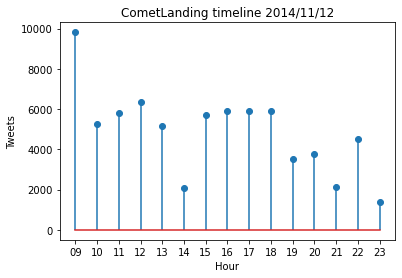

In [78]:
y = date_data
x = date_labels

plt.title("CometLanding timeline 2014/11/12")
plt.xlabel("Hour")
plt.ylabel("Tweets")

plt.stem(x, y)
plt.show()

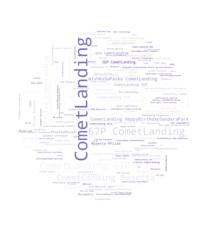

In [79]:
def createWordCloud(allHashtags):
    mask = np.array(Image.open('../moon.jpg'))
    text = " ".join(x.split()[0] for x in allHashtags)
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 12000,
                          height = 9000,
                          #max_words = 200,
                          colormap = 'Purples',
                          mask = mask,
                          background_color = 'white').generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file('../images/wordCloud.png')

# Not sure if CometLanding hashtag should be in cloud but it can be searched for in the file and removed before creating wordcloud.
# Example usage
createWordCloud(getListOfAllHashTags())
